***Generative Adversarial Networks***

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import *
from tqdm import tqdm

## Data Prep

***Downloading dataset***

In [2]:
# !pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp ~/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!sudo unzip "celeba-dataset.zip" -d "/dataset/"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /dataset/img_align_celeba/img_a

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LATENT_DIM=100

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 202599 files.


In [5]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [6]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [7]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


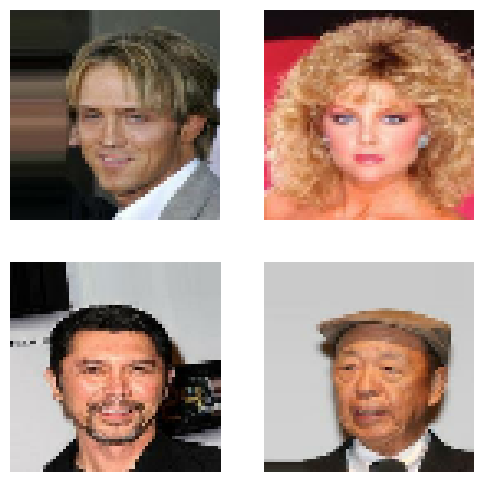

In [9]:
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

In [10]:
def Generator(input_shape=(LATENT_DIM,)):
  inputs = Input(shape=input_shape)
  x = Dense(4*4*512)(inputs)
  x = Reshape((4,4,512))(x)

  x = Conv2DTranspose(512, kernel_size=4, strides=2, padding="same")(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2DTranspose(3, kernel_size=4, strides=2, activation="tanh", padding="same")(x)

  generator = Model(inputs, x)
  return generator

Generator().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,653,763 (29.20 MB)

 Trainable params: 7,651,971 (29.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
def Discriminator(input_shape=IM_SHAPE):
  inputs = Input(shape=input_shape)

  x = Conv2D(64,kernel_size=4,strides=2, padding='same')(inputs)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(128,kernel_size=4,strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(256,kernel_size=4,strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(1,kernel_size=4,strides=2, padding='same')(x)
  x = Flatten()(x)
  x = Dense(1, activation='sigmoid')(x)

  discriminator = Model(inputs, x)
  return discriminator

Discriminator().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 1)             │           4,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [12]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [13]:
!mkdir generated

In [14]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size = tf.shape(real_images)[0]

    ## Discriminator
    noise = tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_imgs = self.generator(noise)

    real_labels = tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels = tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as tape:
      real_predictions = self.discriminator(real_images)
      d_loss_real = self.loss_fn(real_labels,real_predictions)

      fake_predictions = self.discriminator(fake_imgs)
      d_loss_fake = self.loss_fn(fake_labels,fake_predictions)

      d_loss = d_loss_real + d_loss_fake

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    ## Generator
    noise = tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_gen_labels = tf.ones((batch_size,1))

    with tf.GradientTape() as tape:

      fake_predictions = self.discriminator(self.generator(noise))
      g_loss = self.loss_fn(fake_gen_labels, fake_predictions)

    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [15]:
discriminator = Discriminator()
generator = Generator()
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer = Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer = Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
history=gan.fit(train_dataset,epochs=20,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/20
   1582/Unknown 349s 207ms/step - d_loss: 1.1943 - g_loss: 0.8874

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1582/1582 ━━━━━━━━━━━━━━━━━━━━ 351s 209ms/step - d_loss: 1.1943 - g_loss: 0.8873
Epoch 2/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 368s 210ms/step - d_loss: 1.2615 - g_loss: 0.8342
Epoch 3/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 373s 204ms/step - d_loss: 1.2808 - g_loss: 0.7754
Epoch 4/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 381s 204ms/step - d_loss: 1.2840 - g_loss: 0.7517
Epoch 5/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 332s 209ms/step - d_loss: 1.2919 - g_loss: 0.7365
Epoch 6/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 328s 207ms/step - d_loss: 1.2884 - g_loss: 0.7435
Epoch 7/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 332s 210ms/step - d_loss: 1.2811 - g_loss: 0.7476
Epoch 8/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 333s 210ms/step - d_loss: 1.2692 - g_loss: 0.7493
Epoch 9/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 332s 210ms/step - d_loss: 1.2653 - g_loss: 0.7550
Epoch 10/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 332s 210ms/step - d_loss: 1.2732 - g_loss: 0.7554
Epoch 11/20
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 332s 210ms/step - d_loss: 1.2843 - g_loss: 0.76

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()